look at why we get weird blocking of the top results from our first semmeddb full prediction run

In [1]:
import pandas as pd
from scipy import spatial
import numpy

from tqdm import tqdm
import seaborn as sns

In [2]:
%matplotlib inline

## read data

In [3]:
res = pd.read_csv("good_pairs_results_test.tsv", sep='\t')

In [4]:
res.shape

(6147330, 7)

In [5]:
res.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer


## remove any gold standard data

In [6]:
traind = pd.read_csv("data/training/clean_train0.tsv", sep='\t')
holdoutd = pd.read_csv("data/holdout/clean_holdout0.tsv", sep='\t')

In [7]:
trues = (traind
    .query("etype == 1")
    .append(holdoutd.query("etype == 1"))
)

In [8]:
trues.shape

(6329, 5)

In [9]:
trues.head()

,chemical_id,disease_id,etype,chemical_uid,disease_uid
222,C0012471,C0000810,1,4210,123
223,C0012472,C0000810,1,4211,123
460,C0030095,C0000810,1,10052,123
2260,C0062648,C0000880,1,24175,138
3369,C0030827,C0001263,1,10304,304


### how many overlaps?

In [10]:
a = traind.query("etype == 1")
b = holdoutd.query("etype == 1")
all_true = (
    set(zip(a["chemical_uid"], a["disease_uid"]))
    | set(zip(b["chemical_uid"], b["disease_uid"]))
)

In [11]:
len(all_true)

6329

In [12]:
p = set(zip(res["chem_uid"], res["dise_uid"]))

In [13]:
len(p & all_true)

934

---

In [14]:
fin = (res
    .merge(
        trues.rename(columns={
            "chemical_uid": "chem_uid",
            "disease_uid": "dise_uid"
        }), how="left", on=["chem_uid", "dise_uid"]
    )
    .drop(["chemical_id", "disease_id"], axis=1)
)

In [15]:
fin.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name,etype
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer,NaN
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer,NaN
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer,NaN
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer,NaN
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer,NaN


In [16]:
fin.isnull().sum()

chem_uid           0
dise_uid           0
pscore             0
chem_id            0
chem_name          0
dise_id            0
dise_name          0
etype        6146396
dtype: int64

In [17]:
fin["etype"].value_counts()

1.0    934
Name: etype, dtype: int64

## get everything not in gold

In [18]:
good = (fin
    .query("etype != 1.0")
    .drop("etype", axis=1)
)

In [19]:
good.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer


In [20]:
good.shape

(6146396, 7)

---

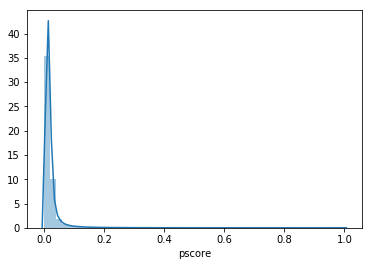

In [29]:
sns.distplot(good["pscore"])

In [21]:
good.query("pscore > 0.5").shape

(22493, 7)

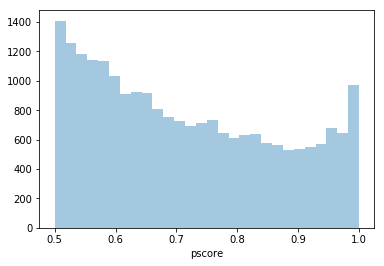

In [22]:
sns.distplot(good.query("pscore > 0.5")["pscore"], kde=False)

the blocking thing i was witnessing earlier was probably because i wasn't sorting the results by descending pscore

seems to go away now, which is good?

## top results

In [27]:
good.head(30)

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer
5,15303,42346,0.999992,C0045093,gemcitabine,C0153423,stomach cancer
6,105038,2708,0.999991,C0661318,1-methyl-1-piperidinomethane sulfonate,C0007873,cervical cancer
7,26770,1528,0.999988,C0067356,"N,N-diethylazasqualene",C0004509,azoospermia
8,105038,196147,0.999987,C0661318,1-methyl-1-piperidinomethane sulfonate,C1458155,breast cancer
9,16711,88348,0.999987,C0049065,5-aza-2'-deoxycytidine,C0496775,esophageal cancer


In [30]:
good.query("pscore > 0.9 and pscore < 0.95").head(30)

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
2519,3084,126351,0.949993,C0008838,Cisplatin,C0949022,rectum cancer
2520,9467,9697,0.949986,C0027996,Nicotinic Acid,C0028754,obesity
2521,16711,2435,0.949906,C0049065,5-aza-2'-deoxycytidine,C0007114,skin cancer
2522,3133,2736,0.949875,C0008996,Clofazimine,C0007965,Chediak-Higashi syndrome
2523,29827,42668,0.949856,C0072973,Ramipril,C0155567,aortic valve stenosis
2524,9749,592,0.949825,C0028908,Oils,C0002103,allergic rhinitis
2525,2189,58182,0.949822,C0006463,Busulfan,C0265965,dyskeratosis congenita
2526,731,88348,0.949775,C0002475,Mitomycin,C0496775,esophageal cancer
2527,26329,11440,0.949740,C0066412,methylnicotinate,C0033860,psoriasis
2528,4258,34915,0.949669,C0012582,Dipyridamole,C0085580,essential hypertension


---

In [33]:
def get_simple_features(fname):
    """Get a dictionary of embeddings for all nodes.
    Faster than iterrowing the feature dataframe by 4x
    """

    res = dict()
    with open(fname, "r") as fin:
        nodes = int(fin.readline().split(" ")[0])

        for line in tqdm(fin, total=210389):
            vals = line.rstrip("\n").split(" ")

            uid = int(vals[0])
            res[uid] = list(map(float, vals[1:]))
            
    return res

In [34]:
sfeats = get_simple_features("data/embeddings/sem50walk128vec10window.txt")

100%|██████████| 210389/210389 [00:11<00:00, 17785.29it/s]


In [35]:
def convolv(chemuid, diseuid):
    """Get convolved features."""
    return [
        sfeats[chemuid][i] * sfeats[diseuid][i]
        for i in range(vecsize)
    ]

---

In [36]:
def similarity(u, v):
    return 1 - spatial.distance.cosine(u, v)

In [38]:
notbad = good.query("pscore > 0.1")

In [39]:
notbad.shape

(178458, 7)

In [41]:
tmp = list()
vecsize = 128

for cuid, duid in tqdm(zip(notbad["chem_uid"], notbad["dise_uid"]), total=len(notbad)):
    simval = similarity(sfeats[cuid], sfeats[duid])
    
    tmp.append(simval)

100%|██████████| 178458/178458 [00:10<00:00, 17230.85it/s]


In [42]:
notbad = notbad.assign(pairsim = tmp)

In [44]:
notbad.head(20)

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name,pairsim
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer,0.597067
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer,0.522366
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer,0.595701
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer,0.603049
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer,0.483557
5,15303,42346,0.999992,C0045093,gemcitabine,C0153423,stomach cancer,0.400375
6,105038,2708,0.999991,C0661318,1-methyl-1-piperidinomethane sulfonate,C0007873,cervical cancer,0.547703
7,26770,1528,0.999988,C0067356,"N,N-diethylazasqualene",C0004509,azoospermia,0.619656
8,105038,196147,0.999987,C0661318,1-methyl-1-piperidinomethane sulfonate,C1458155,breast cancer,0.521425
9,16711,88348,0.999987,C0049065,5-aza-2'-deoxycytidine,C0496775,esophageal cancer,0.497353


## does similarity of the chemical and disease affect probability of being ranked highly?

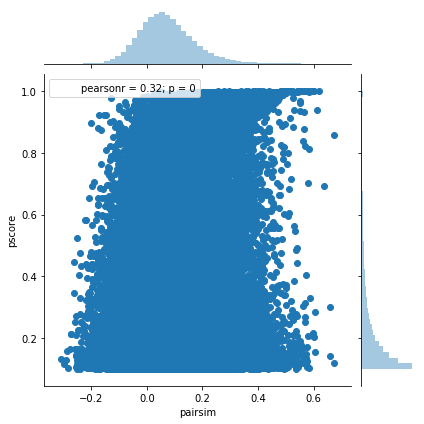

In [45]:
sns.jointplot(data=notbad, x="pairsim", y="pscore")

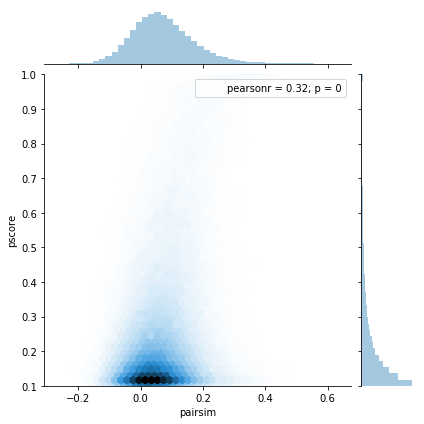

In [46]:
sns.jointplot(
    data=notbad, x="pairsim", y="pscore",
    kind="hex"
)

## similarity to the top result and probability of being ranked highly?

In [47]:
good.sort_values("pscore", ascending=False).head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer


In [48]:
best = good.query("pscore > 0.5")

vecsize = 128

tmp = list()

# top result
topfeats = convolv(105038, 42346)

for cuid, duid in zip(best["chem_uid"], best["dise_uid"]):
    fvec = convolv(cuid, duid)
    
    tmp.append([cuid, duid, similarity(topfeats, fvec)])
    
tmp = pd.DataFrame(tmp, columns=["chem_uid", "dise_uid", "similarity"])

---

In [49]:
fin = best.merge(tmp, how="inner", on=["chem_uid", "dise_uid"])

In [50]:
fin.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name,similarity
0,105038,42346,0.999999,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153423,stomach cancer,1.000000
1,16711,42346,0.999998,C0049065,5-aza-2'-deoxycytidine,C0153423,stomach cancer,0.665743
2,105038,88348,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0496775,esophageal cancer,0.964756
3,105038,42357,0.999997,C0661318,1-methyl-1-piperidinomethane sulfonate,C0153493,lung cancer,0.935080
4,16711,196147,0.999995,C0049065,5-aza-2'-deoxycytidine,C1458155,breast cancer,0.577214


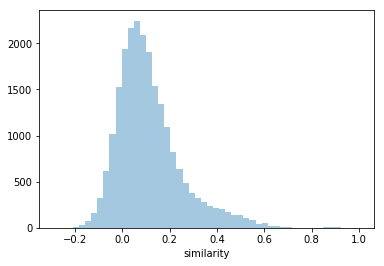

In [51]:
sns.distplot(fin["similarity"], kde=False)

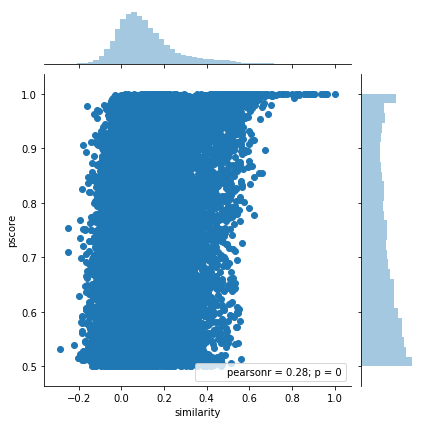

In [52]:
sns.jointplot(data=fin, x="similarity", y="pscore")

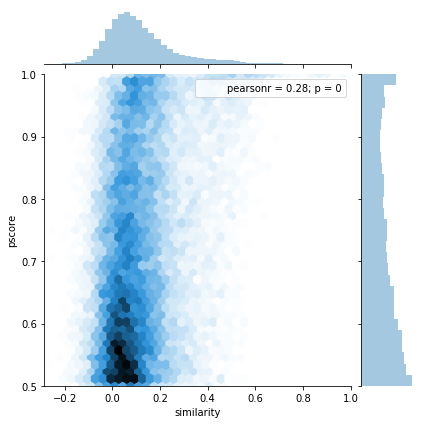

In [53]:
sns.jointplot(data=fin, x="similarity", y="pscore", kind="hex")

for the top results i'm not seeing any sort of obvious correlation between the top result and the ranking

maybe it's time to look at a more random sampling like andrew said